# House Prices Prediction using TensorFlow Decision Forests

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

This notebook will take you through the steps needed to train a baseline Random Forest Model using TensorFlow Decision Forests on the House Prices dataset made available for this competition. We will load the data from a CSV file. Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

## Import the library

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Comment this if the data visualisations doesn't work on your side
# %matplotlib inline

2023-04-08 17:35:52.105452: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 17:35:52.152883: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 17:35:52.154000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 17:35:52.994728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.12.0
TensorFlow Decision Forests v1.3.0


## Load the dataset


In [3]:
train_file_path = "input/HERMPARK_training_data.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1626, 41)


Load the historical sales dataset

In [4]:
hsale_file_path = "input/HERMPARK_training_hsales.csv"
hsales_df = pd.read_csv(hsale_file_path)
print("Full historical sales dataset shape is {}".format(hsales_df.shape))

Full historical sales dataset shape is (667, 28)


The data is composed of 37 columns and 1619 entries. We can see all 37 dimensions of our dataset by printing out the first 3 entries using the following code:

In [5]:
dataset_df.head(3)

,Street Address,Suburb,State,Postcode,Property Type/Category,Bed,Bath,Car,Land Size,Building Area,...,Owner 3 Name,Owner 3 Address,Vendor 1 Name,Vendor 1 Address,Vendor 2 Name,Vendor 2 Address,Vendor 3 Name,Vendor 3 Address,Relationship,Open in RPP
0,1 Ackers Street,Hermit Park,QLD,4812,House,3,2,0,809,0.0,...,NaN,NaN,Shannean Ellen Ruszieta Moncrieff,"C/- LEE TURNBULL & CO PO BOX 1920, TOWNSVILLE ...",Russell James Moncrieff,"C/- LEE TURNBULL & CO PO BOX 1920, TOWNSVILLE ...",NaN,NaN,NaN,https://rpp.rpdata.com/rpp/property/detail.htm...
1,1/2-12 Ackers Street,Hermit Park,QLD,4812,Unit,3,1,2,462,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://rpp.rpdata.com/rpp/property/detail.htm...
2,7 Ackers Street,Hermit Park,QLD,4812,Unit,0,0,0,809,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://rpp.rpdata.com/rpp/property/detail.htm...


In [6]:
hsales_df.head(3)

,Street Address,Suburb,State,Postcode,Property Type,Bed,Bath,Car,Land Size (m²),Floor Size (m²),...,Development Zone,Parcel Details,Owner 1 Name,Owner 2 Name,Owner 3 Name,Owner Type,Vendor 1 Name,Vendor 2 Name,Vendor 3 Name,Open in RPData
0,19 ACKERS STREET,HERMIT PARK,QLD,4812,House: One Storey / Lowset,5,3,2,478,270,...,NOT ZONED,3/SP186223,STEVEN RAYMOND MORISH,-,-,Owner Occupied,ROBERT MICHAEL STANIER,NONI LOUISE OLSEN,-,https://rpp.corelogic.com.au/property/19-acker...
1,1 ACKERS STREET,HERMIT PARK,QLD,4812,House,3,2,-,809,152,...,RESIDENTIAL - NEIGHBOURHOOD,237/RP703399,KATIE MAREE KEAM,ZACHARY ALEXANDER KEAM,-,Owner Occupied,SHANNEAN ELLEN RUSZIETA MONCRIEFF,RUSSELL JAMES MONCRIEFF,-,https://rpp.corelogic.com.au/property/1-ackers...
2,3/7 ACKERS STREET,HERMIT PARK,QLD,4812,Unit: Standard,2,1,1,31,111,...,RESIDENTIAL - NEIGHBOURHOOD,3/BUP70031,WASSIM HURMIZ,-,-,Rented,NESRIN HARRISON,-,-,https://rpp.corelogic.com.au/property/3-7-acke...


* There are 37 feature columns. Using these features your model has to predict the house sale price indicated by the label column named `SalePrice`.

# Blend Historical Sales with Current Records

Dataset_df only contains the last sale.  Hsales_df contains all previous sales, plus a Year Built column.  The Historical Sales dataset needs to be merged into the Current Records dataset.

* Convert the 'Open in RPP' fields to identifier fields in both sets.
* Retrieve the 'Year Built' data from Historical into Current.
* Remove 'current' sale record from Historical data set.
* Retrieve all other feature columns from Current into Historical.
* Add Historical records to Current data set.
* Use Groupby and Shift functions to create 'Time Since Last Sale', 'Pct Growth Since Last Sale' columns.


In [7]:
# Convert the 'Open in RPP' fields to identifier fields in both sets.
dataset_df['rppid'] = dataset_df['Open in RPP'].map(lambda x: x.strip('https://rpp.rpdata.com/rpp/property/detail.html?propertyId='))
hsales_df['rppid'] = hsales_df['Open in RPData'].str.rpartition('/')[2]

# Retrieve the 'Year Built' data from Historical into Current.
dataset_df = dataset_df.merge(hsales_df, how='left', left_on='rppid', right_on='rppid')

# remove current sale record from Historical data set
## split dataframe into features and transactions
## merge historical and current transaction data records on yearsold - month sold - sale price - rppid

## drop duplicates from merged transactions dataframe

# calculate time since last sale
# calculate growth since last sale


We will drop the `Id` column as it is not necessary for model training.  Remove all Owner and Vendor, Relationship details and others that are not relevant at present.

In [8]:
#drop columns from merge
dataset_df = dataset_df.drop(['Street Address_x','Suburb_x','State_x','Postcode_x','Settlement Date_x', 'Agency_x','Agent_x','Improve/Improvement','Construction','Primary plan/Lot Plan','RPD','Valuation No','Owner 1 Name_x','Owner 1 Address','Owner 2 Name_x','Owner 2 Address','Owner 3 Name_x','Owner 3 Address','Relationship','Vendor 1 Name_x','Vendor 1 Address','Vendor 2 Name_x','Vendor 2 Address','Vendor 3 Name_x','Vendor 3 Address','Street Address_y','Suburb_y','State_y','Postcode_y','Open in RPP', 'Open in RPData', 'Bed_y','Bath_y', 'Car_y','Land Size (m²)','Floor Size (m²)','Vendor 1 Name_y','Vendor 2 Name_y','Vendor 3 Name_y','Owner Type','Sale Price_y','Sale Date_y','Settlement Date_y','Sale Type_y','Development Zone_y','Owner 1 Name_y','Owner 2 Name_y','Owner 3 Name_y','Property Type','Agency_y','Agent_y','Land Use','Parcel Details'], axis=1)

dataset_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1626 entries, 0 to 1625
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Property Type/Category  1626 non-null   object 
 1   Bed_x                   1626 non-null   int64  
 2   Bath_x                  1626 non-null   int64  
 3   Car_x                   1626 non-null   int64  
 4   Land Size               1626 non-null   int64  
 5   Building Area           1626 non-null   float64
 6   Sale Price_x            1626 non-null   object 
 7   Sale Date_x             1384 non-null   object 
 8   Sale Type_x             1384 non-null   object 
 9   Land Use 1              1553 non-null   object 
 10  Zoning                  1543 non-null   object 
 11  Development Zone_x      1533 non-null   object 
 12  Valuation Type          1626 non-null   object 
 13  Valuation Amount        1626 non-null   object 
 14  Valuation Date          1067 non-null   

### Strip spaces from Column Names


In [9]:
dataset_df.rename(columns={"Land Size": "LandSize", "Building Area": "BuildingArea", "Sale Price_x": "SalePrice", "Sale Date_x": "SaleDate", "Sale Type_x": "SaleType", "Land Use 1": "LandUse1", "Development Zone_x": "DevelopmentZone", "Valuation Type": "ValuationType", "Valuation Amount": "ValuationAmount", "Valuation Date": "ValuationDate", "Year Built":"YearBuilt"}, inplace=True)

### Convert to NaN, Convert Data Types

A number of columns in the original dataset require the value 0 to be converted to NaN.
A number of columns also need to be converted to a numeric data type.

In [10]:
dataset_df['Bed_x'].replace(0, np.nan, inplace=True)
dataset_df['Bath_x'].replace(0, np.nan, inplace=True)
dataset_df['Car_x'].replace(0, np.nan, inplace=True)
dataset_df['BuildingArea'].replace(0, np.nan, inplace=True)

dataset_df['SalePrice'].replace("$0", np.nan, inplace=True)
dataset_df['SalePrice'].replace("Not Disclosed", np.nan, inplace=True)
dataset_df['SalePrice'] = dataset_df['SalePrice'].str.replace('$','')
dataset_df['SalePrice'] = dataset_df['SalePrice'].str.replace(',','')

dataset_df['ValuationAmount'].replace("$0", np.nan, inplace=True)
dataset_df['ValuationAmount'] = dataset_df['ValuationAmount'].str.replace('$','')
dataset_df['ValuationAmount'] = dataset_df['ValuationAmount'].str.replace(',','')

# convert string columns to numeric
dataset_df['ValuationAmount']   = pd.to_numeric(dataset_df['ValuationAmount'])
dataset_df['SalePrice']         = pd.to_numeric(dataset_df['SalePrice'])

# Where SaleDate is 1-Jan-30 also needs to be converted to NaN
dataset_df['SaleDate'].replace("1-Jan-30", np.nan, inplace=True)

# convert string columns to dates
dataset_df['SaleDate']   = pd.to_datetime(dataset_df['SaleDate'], format="%d-%b-%y")
dataset_df['ValuationDate']   = pd.to_datetime(dataset_df['ValuationDate'], format="%d-%b-%y")


dataset_df.head(3)

/tmp/ipykernel_1596/3418029331.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dataset_df['SalePrice'] = dataset_df['SalePrice'].str.replace('$','')
/tmp/ipykernel_1596/3418029331.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dataset_df['ValuationAmount'] = dataset_df['ValuationAmount'].str.replace('$','')


,Property Type/Category,Bed_x,Bath_x,Car_x,LandSize,BuildingArea,SalePrice,SaleDate,SaleType,LandUse1,Zoning,DevelopmentZone,ValuationType,ValuationAmount,ValuationDate,rppid,YearBuilt
0,House,3.0,2.0,NaN,809,NaN,194000.0,2021-05-04,Normal Sale,Single Unit Dwelling,RESIDENTIAL - NEIGHBOURHOOD,Character Residential,SV,89000.0,2022-06-30,5024762,1920
1,Unit,3.0,1.0,2.0,462,NaN,NaN,NaT,NaN,NaN,NaN,NaN,UCV,NaN,NaT,47670361,NaN
2,Unit,NaN,NaN,NaN,809,NaN,NaN,NaT,NaN,Building Units (Primary Use Only),RESIDENTIAL - NEIGHBOURHOOD,Character Residential,SV,202500.0,2022-06-30,5024770,NaN


### Convert Columns to Categories

Convert some columns to categorical data.

In [11]:
# SaleType column
dataset_df['SaleType'].replace('Normal Sale','NM', inplace=True)
dataset_df['SaleType'].replace('Unknown','UN', inplace=True)
dataset_df['SaleType'].replace('Part Sale','PA', inplace=True)
dataset_df['SaleType'].replace('Family Sale','FA', inplace=True)
dataset_df['SaleType'].replace('Transmission By Death','TR', inplace=True)
dataset_df['SaleType'].replace('Multi-Sale','MS', inplace=True)
dataset_df['SaleType'].replace('Transfer By Third Party','TF', inplace=True)
dataset_df['SaleType'].replace('Court Order','CO', inplace=True)
dataset_df['SaleType'].replace('Rebated Sale''RE', inplace=True)

#dataset_df['SaleType'] = dataset_df['SaleType'].fillna("Unknown", inplace=True)
#dataset_df['SaleType'] = dataset_df['SaleType'].astype("category")

# Zoning
dataset_df['Zoning'].replace('Normal Sale','NM', inplace=True)
dataset_df['Zoning'].replace('NOT ZONED', 'NOT', inplace=True)
dataset_df['Zoning'].replace('RESIDENTIAL - MIXED (7000)', 'MIX', inplace=True)
dataset_df['Zoning'].replace('RESIDENTIAL - NEIGHBOURHOOD', 'NBH', inplace=True)
dataset_df['Zoning'].replace('RESIDENTIAL - TRADITIONAL (7000)', 'TRD', inplace=True)

#dataset_df['Zoning'] = dataset_df['Zoning'].fillna("Unknown", inplace=True)
#dataset_df['Zoning'] = dataset_df['Zoning'].astype("category")

# LandUse1
dataset_df['LandUse1'].replace('Building Units (Primary Use Only)','BUP', inplace=True)
dataset_df['LandUse1'].replace('Group Title (Primary Use Only)','GTP', inplace=True)
dataset_df['LandUse1'].replace('Guest House/Private Hotel','GHS', inplace=True)
dataset_df['LandUse1'].replace('Multi Unit Dwelling (Flats)','MUD', inplace=True)
dataset_df['LandUse1'].replace('Single Unit Dwelling','HSE', inplace=True)
dataset_df['LandUse1'].replace('Vacant Urban Land','LND', inplace=True)

#dataset_df['LandUse1'] = dataset_df['LandUse1'].fillna("Unknown", inplace=True)
#dataset_df['LandUse1'] = dataset_df['LandUse1'].astype("category")

# DevelopmentZone
dataset_df['DevelopmentZone'].replace('Normal Sale','NM', inplace=True)
dataset_df['DevelopmentZone'].replace('Character Residential','CHAR', inplace=True)
dataset_df['DevelopmentZone'].replace('Low Density Residential','LRES', inplace=True)
dataset_df['DevelopmentZone'].replace('Mixed Use','MIXU', inplace=True)

#dataset_df['DevelopmentZone'] = dataset_df['DevelopmentZone'].fillna("Unknown", inplace=True)
#dataset_df['DevelopmentZone'] = dataset_df['DevelopmentZone'].astype("category")

#dataset_df['ValuationType'] = dataset_df['ValuationType'].fillna("Unknown", inplace=True)
#dataset_df['ValuationType'] = dataset_df['ValuationType'].astype("category")


dataset_df.head(3)

,Property Type/Category,Bed_x,Bath_x,Car_x,LandSize,BuildingArea,SalePrice,SaleDate,SaleType,LandUse1,Zoning,DevelopmentZone,ValuationType,ValuationAmount,ValuationDate,rppid,YearBuilt
0,House,3.0,2.0,NaN,809,NaN,194000.0,2021-05-04,NM,HSE,NBH,CHAR,SV,89000.0,2022-06-30,5024762,1920
1,Unit,3.0,1.0,2.0,462,NaN,NaN,NaT,NaN,NaN,NaN,NaN,UCV,NaN,NaT,47670361,NaN
2,Unit,NaN,NaN,NaN,809,NaN,NaN,NaT,NaN,BUP,NBH,CHAR,SV,202500.0,2022-06-30,5024770,NaN


## Convert Dates to Year and Month Columns

Tensors cannot be created from datetime arrays, so to extract just key data three date columns need to be converted into 6 columns.

In [12]:
# create YrSaleDate column
dataset_df['YrSaleDate'] = dataset_df['SaleDate'].dt.year
# create MthSaleDate column
dataset_df['MthSaleDate'] = dataset_df['SaleDate'].dt.month
# create YrValuationDate column
dataset_df['YrValuationDate'] = dataset_df['ValuationDate'].dt.year
# create MthValuationDate column
dataset_df['MthValuationDate'] = dataset_df['ValuationDate'].dt.month

# drop date columns
dataset_df = dataset_df.drop(['SaleDate','ValuationDate'], axis=1)

dataset_df.head(3)

,Property Type/Category,Bed_x,Bath_x,Car_x,LandSize,BuildingArea,SalePrice,SaleType,LandUse1,Zoning,DevelopmentZone,ValuationType,ValuationAmount,rppid,YearBuilt,YrSaleDate,MthSaleDate,YrValuationDate,MthValuationDate
0,House,3.0,2.0,NaN,809,NaN,194000.0,NM,HSE,NBH,CHAR,SV,89000.0,5024762,1920,2021.0,5.0,2022.0,6.0
1,Unit,3.0,1.0,2.0,462,NaN,NaN,NaN,NaN,NaN,NaN,UCV,NaN,47670361,NaN,NaN,NaN,NaN,NaN
2,Unit,NaN,NaN,NaN,809,NaN,NaN,NaN,BUP,NBH,CHAR,SV,202500.0,5024770,NaN,NaN,NaN,2022.0,6.0


### Remove rows where SalePrice is missing

If we don't know the historical sale price, the property is of no use in training.

In [13]:
dataset_df.dropna(subset=['SalePrice'], inplace=True)

We can inspect the types of feature columns using the following code:

In [14]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1353 entries, 0 to 1625
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Property Type/Category  1353 non-null   object 
 1   Bed_x                   1190 non-null   float64
 2   Bath_x                  1170 non-null   float64
 3   Car_x                   1161 non-null   float64
 4   LandSize                1353 non-null   int64  
 5   BuildingArea            599 non-null    float64
 6   SalePrice               1353 non-null   float64
 7   SaleType                1353 non-null   object 
 8   LandUse1                1352 non-null   object 
 9   Zoning                  1342 non-null   object 
 10  DevelopmentZone         1337 non-null   object 
 11  ValuationType           1353 non-null   object 
 12  ValuationAmount         828 non-null    float64
 13  rppid                   1353 non-null   object 
 14  YearBuilt               663 non-null    

## House Price Distribution

Now let us take a look at how the house prices are distributed.

count       1353.000000
mean      266666.779749
std       159539.417663
min         3500.000000
25%       148000.000000
50%       235000.000000
75%       365000.000000
max      1000000.000000
Name: SalePrice, dtype: float64


/tmp/ipykernel_1596/3430012634.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


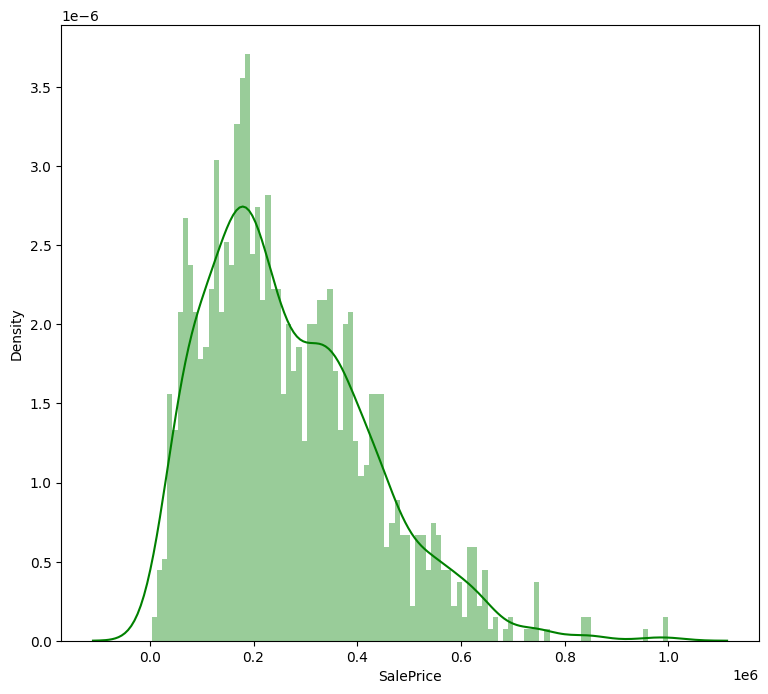

In [15]:
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Numerical data distribution

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [16]:
list(set(dataset_df.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [17]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,Bed_x,Bath_x,Car_x,LandSize,BuildingArea,SalePrice,ValuationAmount,YrSaleDate,MthSaleDate,YrValuationDate,MthValuationDate
0,3.0,2.0,NaN,809,NaN,194000.0,89000.0,2021.0,5.0,2022.0,6.0
3,2.0,1.0,1.0,31,87.0,65000.0,NaN,2000.0,7.0,NaN,NaN
4,2.0,1.0,1.0,31,87.0,180000.0,NaN,2006.0,5.0,NaN,NaN
5,2.0,1.0,1.0,31,87.0,169000.0,NaN,2022.0,10.0,NaN,NaN
7,2.0,1.0,1.0,31,87.0,170000.0,NaN,2022.0,11.0,NaN,NaN


Now let us plot the distribution for all the numerical features.

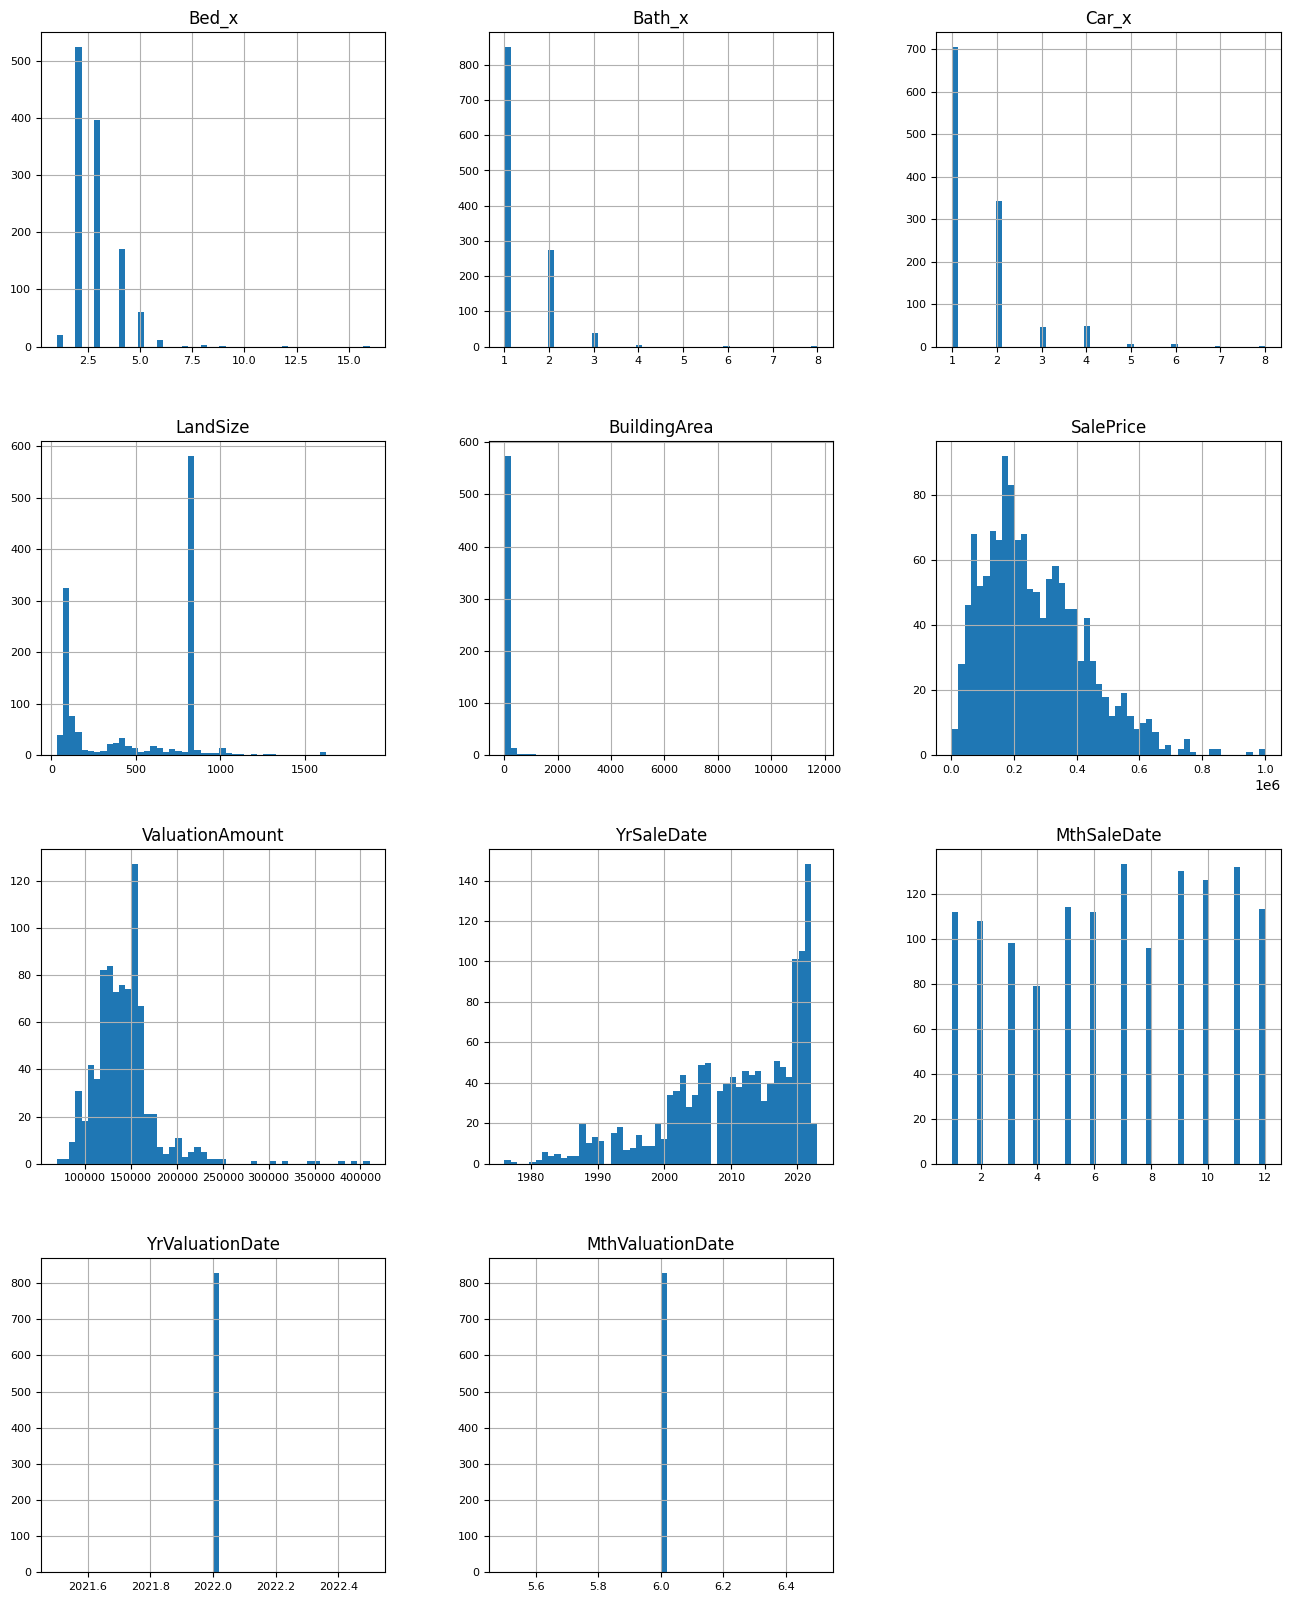

In [18]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## Prepare the dataset

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

### Treat  Missing Values

Despite the above, currently missing values, blanks and zeros are represented the same way in the dataset.  In specific columns, zeros need to be converted to NaN, as do blanks.

> In the original Hermit Park dataset, there were 7 properties without LandSize. These were deleted.

### Roll Back Current Month Sales

Do this later.

Now let us split the dataset into training and testing datasets:

In [19]:
def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

968 examples in training, 385 examples in testing.


There's one more step required before we can train the model. We need to convert the datatset from Pandas format (`pd.DataFrame`) into TensorFlow Datasets format (`tf.data.Dataset`).

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

By default the Random Forest Model is configured to train classification tasks. Since this is a regression problem, we will specify the type of the task (`tfdf.keras.Task.REGRESSION`) as a parameter here.

In [20]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

2023-04-08 17:36:00.348711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-08 17:36:00.349348: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [21]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

## How can I configure them?

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

## Create a Random Forest

Today, we will use the defaults to create the Random Forest Model while specifiyng the task type as `tfdf.keras.Task.REGRESSION`.

In [22]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

Use /tmp/tmplz_zvp93 as temporary training directory


## Train the model

We will train the model using a one-liner.

Note: you may see a warning about Autograph. You can safely ignore this, it will be fixed in the next release.

In [23]:
rf.fit(x=train_ds)

Reading training dataset...


2023-04-08 17:36:00.759378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [968]
	 [[{{node Placeholder/_7}}]]


Training dataset read in 0:00:03.776037. Found 968 examples.
Training model...


[INFO 23-04-08 17:36:04.8874 AEST kernel.cc:1242] Loading model from path /tmp/tmplz_zvp93/model/ with prefix b2e57eae9c724a9f


Model trained in 0:00:00.713922
Compiling model...


[INFO 23-04-08 17:36:05.2018 AEST decision_forest.cc:660] Model loaded with 300 root(s), 90056 node(s), and 15 input feature(s).
[INFO 23-04-08 17:36:05.2019 AEST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-04-08 17:36:05.2019 AEST kernel.cc:1074] Use fast generic engine
2023-04-08 17:36:05.251311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype string and shape [968]
	 [[{{node Placeholder/_9}}]]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


## Visualize the model
One benefit of tree-based models is that you can easily visualize them. The default number of trees used in the Random Forests is 300. We can select a tree to display below.

In [24]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

## Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training the dataset we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model.The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the Root Mean Squared Error (RMSE) evaluated on the out-of-bag dataset according to the number of trees in the model. Let us plot this.

Note: Smaller values are better for this hyperparameter.

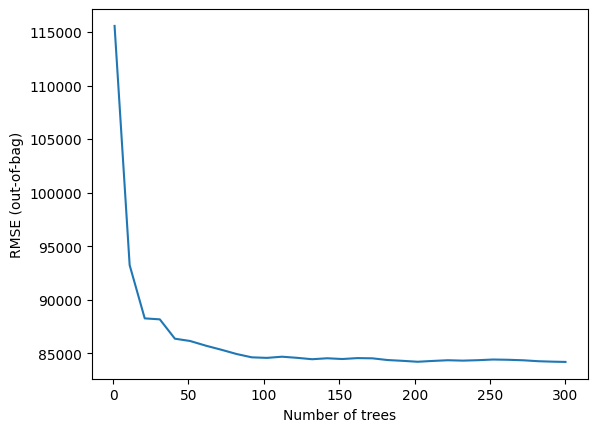

In [25]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

We can also see some general stats on the OOB dataset:

In [26]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=968, accuracy=None, loss=None, rmse=84190.59207767926, ndcg=None, aucs=None, auuc=None, qini=None)

### Normalized Root Mean Square Error

The Normalized Root Mean Square Error (NRMSE) the RMSE facilitates the comparison between models with different scales. The normalised RMSE (NRMSE) which relates the RMSE to the observed range of the variable. Thus, the NRMSE can be interpreted as a fraction of the overall range that is typically resolved by the model.

In [27]:
rmse = inspector.evaluation().rmse
obs_mean = dataset_df['SalePrice'].mean()
nrmse = (rmse/obs_mean)
print(f"RMSE ${rmse:.2f} Mean of SalePrice ${obs_mean:.2f} giving NRMSE {nrmse:.2%}")

RMSE $84190.59 Mean of SalePrice $266666.78 giving NRMSE 31.57%


Now, let us run an evaluation using the validation dataset.

In [28]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

2023-04-08 17:36:07.728455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype double and shape [385]
	 [[{{node Placeholder/_8}}]]


1/1 [==============================] - 0s 363ms/step - loss: 0.0000e+00 - mse: 7277437952.0000
loss: 0.0000
mse: 7277437952.0000


## Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

In [29]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [30]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("Bed_x" (1; #1), 118.0),
 ("YrSaleDate" (1; #14), 77.0),
 ("Car_x" (1; #3), 59.0),
 ("Bath_x" (1; #0), 25.0),
 ("LandSize" (1; #5), 8.0),
 ("LandUse1" (4; #6), 8.0),
 ("YearBuilt" (4; #13), 3.0),
 ("Property_Type/Category" (4; #9), 2.0)]

Plot the variable importances from the inspector using Matplotlib

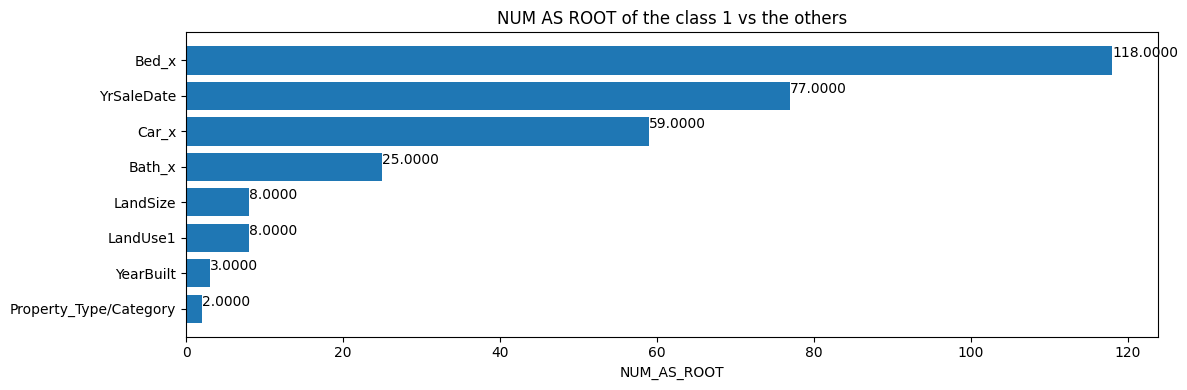

In [31]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

# Submission
Finally predict on the competition test data using the model.

In [32]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()


FileNotFoundError: [Errno 2] No such file or directory: '../input/house-prices-advanced-regression-techniques/test.csv'

In [ ]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

# Future enhancements

Consider if the following enhance predictive power:
* Postcode of vendor and purchaser
* State of vendor and purchaser
* Agent or agency details involved in the transaction
* Get ALL historical sales, not just the last 3 years
* Blend other datasets, for example GeoNAT